In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
%matplotlib inline
import torch
from deepseries.models import BasicSeq2Seq
from deepseries.dataset import Property, TimeSeries, Seq2SeqDataLoader
from deepseries.nn.loss import MSELoss, RMSELoss
from deepseries.train import Learner
from deepseries.optim import ReduceCosineAnnealingLR
import deepseries.functional as F
from deepseries.analysis import SeriesAnalysisModel
from torch.optim import Adam
from torch import nn
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error
import chinese_calendar as calendar
import datetime as dt
info = pd.read_excel("../data/info.xlsx")
recored = info.set_index("contributor_id")['huangzf']
info = pd.read_excel("../data/info.xlsx").set_index("contributor_id")[['pjt_name', 'pjt_type']]
norm_score = pd.read_csv(r"../data/20200315_20200415.csv")

In [2]:
# util function

def normalize(x, axis, fill_zero=True):
    mu = np.nanmean(x, axis, keepdims=True)
    std = np.nanstd(x, axis, keepdims=True)
    x_norm = (x - mu) / std
    if fill_zero:
        x_norm = np.nan_to_num(x_norm)
    return x_norm, mu, std

In [3]:
power = pd.read_csv('../data/df.csv', parse_dates=['data_time'])[['data_time', 'cid', 'value']]
power = power.set_index("data_time").groupby("cid").resample("1H").sum().reset_index()
power = power.pivot(index='cid', columns='data_time', values='value')
power = power.apply(np.log1p)

In [4]:
analysis = SeriesAnalysisModel(power.values)

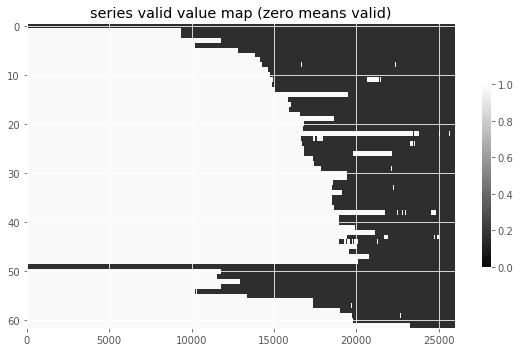

In [5]:
analysis.plot_valid()

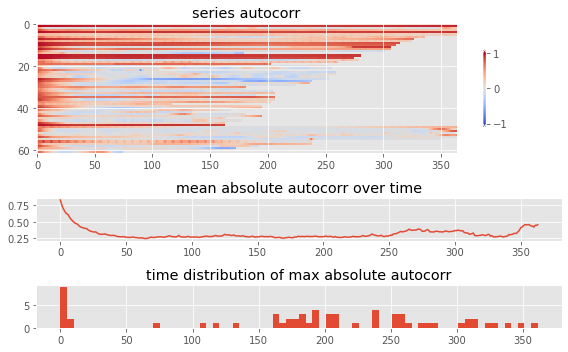

In [6]:
analysis.get_autocorr(np.arange(24*1, 24*365, 24)).plot_autocorr()

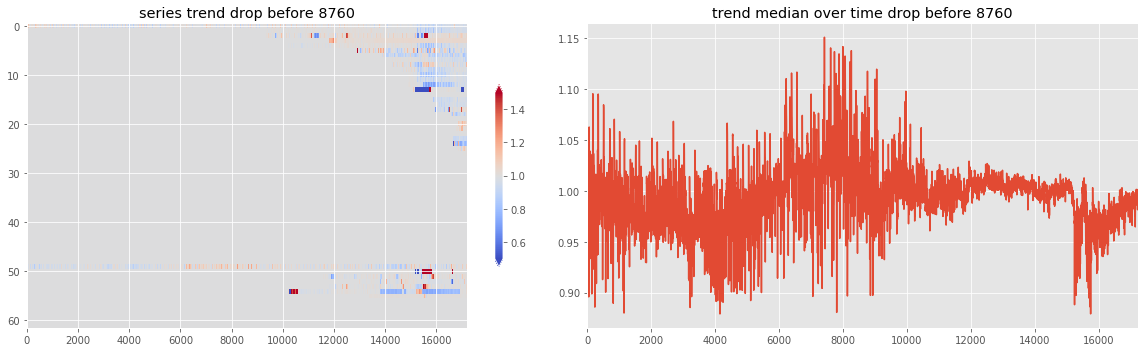

In [7]:
analysis.get_trend(max_T=365*24).plot_trend()

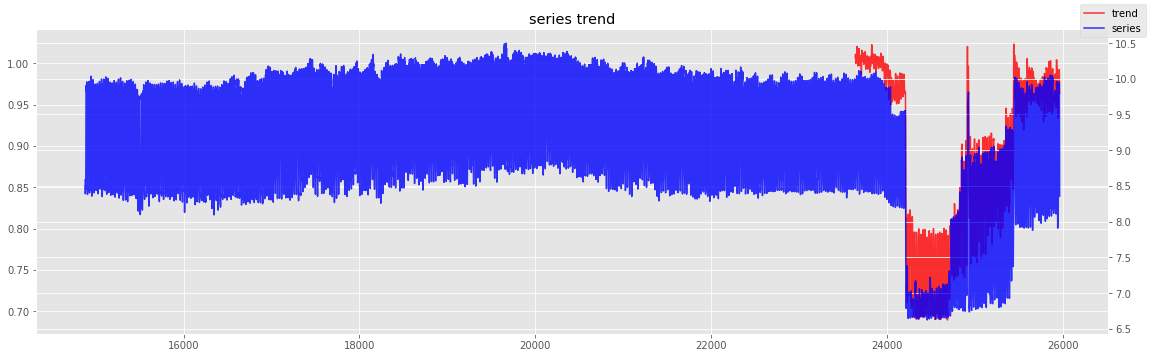

In [8]:
analysis.plot_trend(12)

In [9]:
N_TEST = 24 * 30
N_VALID = 24 * 2
DROP_ZERO = True
DEC_LEN = 24 * 2
ENC_LEN = 24 * 7
time_free_space = 24

drop_before = 15000

In [10]:
xy = power.values

xy_valid = np.bitwise_and(~np.isnan(xy), xy!=0)
starts, ends = F.get_valid_start_end(xy, ~xy_valid)


xy, xy_mean, xy_std = normalize(xy, axis=1)
power = (power - xy_mean) / xy_std

In [11]:
xy_auto_corr = F.batch_autocorr(xy, [7*24, 14*24, 180*24, 365*24], starts, ends, 1.05)
xy_auto_corr, _, _ = normalize(xy_auto_corr, 0)

In [12]:
xy_lags, _, _ = normalize(F.make_lags(xy, [7*24, 14*24, 180*24, 365*24]), axis=2)
xy_valid = np.expand_dims(xy_valid.astype("float32"), 1)
xy_lag_valid = np.concatenate([xy_lags,  xy_valid], axis=1).astype("float32")

In [13]:
weights = (xy_valid.astype("float32") + 1e-6 ).squeeze()
weights = weights * xy_mean / xy_mean.mean()
weights[:, np.where((power.columns >= "2020-02-01") & (power.columns < "2020-03-01"), 1, 0)] = \
weights[:, np.where((power.columns >= "2020-02-01") & (power.columns < "2020-03-01"), 1, 0)] * 0.1
weights = np.expand_dims(weights, 1)

In [14]:
def get_holiday_features(dts):
    select_holidays = ["Spring Festival", "National Day", "Labour Day", "New Year's Day", "Mid-autumn Festival", "Tomb-sweeping Day"]
    def _get_holidays(x):
        is_holiday, holiday_name = calendar.get_holiday_detail(x)
        if holiday_name in select_holidays and is_holiday:
            return holiday_name
    holidays = pd.get_dummies(pd.Series(dts).apply(lambda x: _get_holidays(x)))
    holidays['sick'] = np.where((power.columns >= "2020-02-01") & (power.columns < "2020-03-01"), 1, 0)
    holidays.index= dts
    return holidays

def holiday_apply(x, holidays, func):
    result = pd.DataFrame()
    for h in holidays.columns:
        result[h] = x.loc[:, holidays[h].values.astype(bool)].agg(func, axis=1).values
    return result

holidays = get_holiday_features(power.columns)
xy_holiday_mean = holiday_apply(power, holidays, np.mean).values

xy_holiday_mean = normalize(xy_holiday_mean, 0)[0]

In [15]:
def periodic_feature(x, T):
    psin = np.sin(x * np.pi * 2 / T)
    pcos = np.cos(x * np.pi * 2 / T)
    return np.stack([psin, pcos], axis=0)


# xy_weekday = np.repeat(
#     np.expand_dims(
#         periodic_feature(power.columns.weekday.values, 7), axis=0), xy.shape[0], axis=0)

# xy_hour = np.repeat(
#     np.expand_dims(
#         periodic_feature(power.columns.hour.values, 24), axis=0), xy.shape[0], axis=0)

# xy_month = np.repeat(
#     np.expand_dims(
#         periodic_feature(power.columns.month.values, 12), axis=0), xy.shape[0], axis=0)

xy_weekday = pd.get_dummies(power.columns.weekday).T.values
xy_hour = pd.get_dummies(power.columns.hour).T.values
xy_month = pd.get_dummies(power.columns.month).T.values
xy_date = np.concatenate([xy_weekday, xy_hour, xy_month, holidays.T], 0)
xy_date = np.repeat(np.expand_dims(xy_date, 0), xy.shape[0], axis=0)

In [16]:
xy = np.expand_dims(xy, 1).transpose(0, 2, 1)[:, drop_before:]
xy_property_num = np.concatenate([xy_holiday_mean, xy_auto_corr], axis=1) # 62 x 11
xy_series_num = np.concatenate([xy_lag_valid, xy_date], 1).transpose(0, 2, 1)[:, drop_before:]
weights = weights.transpose(0, 2, 1)[:, drop_before:]

In [17]:
class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        if valid_size < 1:
            valid_size = int(np.floor(len(time_idx) * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx
    
spliter = ForwardSpliter()
train_idx, valid_idx = spliter.split(np.arange(xy.shape[1]), ENC_LEN, DEC_LEN, N_TEST+N_VALID)
valid_idx, test_idx = spliter.split(valid_idx, ENC_LEN, DEC_LEN, N_TEST)

train_xy = TimeSeries(xy[:,train_idx])
valid_xy = TimeSeries(xy[:,valid_idx])

train_xy_features = TimeSeries(xy_series_num[:, train_idx])
valid_xy_features = TimeSeries(xy_series_num[:, valid_idx])

train_xy_property_num = Property(xy_property_num)
valid_xy_property_num = Property(xy_property_num)

train_weight = TimeSeries(weights[:, train_idx])
valid_weight = TimeSeries(weights[:, valid_idx])

train_frame = Seq2SeqDataLoader(train_xy, batch_size=8, enc_lens=ENC_LEN, dec_lens=DEC_LEN, use_cuda=True, mode='train', time_free_space=24,
                          enc_num_feats=[train_xy_features, train_xy_property_num], 
                                dec_num_feats=[train_xy_features, valid_xy_property_num], 
                                weights=train_weight, seq_last=False)
valid_frame = Seq2SeqDataLoader(valid_xy, batch_size=64, enc_lens=ENC_LEN, dec_lens=DEC_LEN, use_cuda=True, mode='train', time_free_space=0,
                         time_interval=48, 
                                enc_num_feats=[train_xy_features, train_xy_property_num], 
                                dec_num_feats=[train_xy_features, valid_xy_property_num], 
                                seq_last=False)

test_xy = xy[:, test_idx]
test_xy_num_feats = np.concatenate([xy_series_num[:, test_idx], np.repeat(np.expand_dims(xy_property_num, 1), len(test_idx), 1)], axis=2)

In [18]:
valid_xy_property_num.values.shape

(62, 11)

In [19]:
train_xy_features.values.shape

(62, 10200, 55)

In [20]:
model = BasicSeq2Seq(1, 512, enc_num=66, dec_num=66, n_layers=1, dropout=0.2)
opt = Adam(model.parameters(), 0.001)
loss_fn = MSELoss()
model.cuda()
lr_scheduler = ReduceCosineAnnealingLR(opt, 64, eta_min=1e-5)
learner = Learner(model, opt, loss_fn, './power_env_rnn', verbose=5000, lr_scheduler=lr_scheduler)
learner.fit(1000, train_frame, valid_frame, patient=64, start_save=1, early_stopping=False)

[[04/29/2020 17:04:18]] start training >>>>>>>>>>>  see log: tensorboard --logdir ./power_env_rnn\logs
[[04/29/2020 17:04:21]] epoch 1 / 1000, batch 100%, train loss 0.3242, valid loss 0.6790, cost 0.0 min
[[04/29/2020 17:04:23]] epoch 2 / 1000, batch 100%, train loss 0.2824, valid loss 0.6908, cost 0.0 min
[[04/29/2020 17:04:26]] epoch 3 / 1000, batch 100%, train loss 0.3865, valid loss 0.5769, cost 0.0 min
[[04/29/2020 17:04:28]] epoch 4 / 1000, batch 100%, train loss 0.2659, valid loss 0.6437, cost 0.0 min
[[04/29/2020 17:04:30]] epoch 5 / 1000, batch 100%, train loss 0.2066, valid loss 0.6953, cost 0.0 min
[[04/29/2020 17:04:33]] epoch 6 / 1000, batch 100%, train loss 0.3866, valid loss 0.6594, cost 0.0 min
[[04/29/2020 17:04:35]] epoch 7 / 1000, batch 100%, train loss 0.4033, valid loss 0.7691, cost 0.0 min
[[04/29/2020 17:04:37]] epoch 8 / 1000, batch 100%, train loss 0.5070, valid loss 0.7283, cost 0.0 min
[[04/29/2020 17:04:40]] epoch 9 / 1000, batch 100%, train loss 0.2289, va

[[04/29/2020 17:07:24]] epoch 78 / 1000, batch 100%, train loss 0.3370, valid loss 0.5305, cost 0.0 min
[[04/29/2020 17:07:26]] epoch 79 / 1000, batch 100%, train loss 0.1074, valid loss 0.5248, cost 0.0 min
[[04/29/2020 17:07:29]] epoch 80 / 1000, batch 100%, train loss 0.5130, valid loss 0.5153, cost 0.0 min
[[04/29/2020 17:07:31]] epoch 81 / 1000, batch 100%, train loss 0.2521, valid loss 0.5199, cost 0.0 min
[[04/29/2020 17:07:33]] epoch 82 / 1000, batch 100%, train loss 0.1305, valid loss 0.5228, cost 0.0 min
[[04/29/2020 17:07:36]] epoch 83 / 1000, batch 100%, train loss 0.4210, valid loss 0.5348, cost 0.0 min
[[04/29/2020 17:07:38]] epoch 84 / 1000, batch 100%, train loss 0.2763, valid loss 0.5337, cost 0.0 min
[[04/29/2020 17:07:40]] epoch 85 / 1000, batch 100%, train loss 0.1872, valid loss 0.4975, cost 0.0 min
[[04/29/2020 17:07:43]] epoch 86 / 1000, batch 100%, train loss 0.2493, valid loss 0.4789, cost 0.0 min
[[04/29/2020 17:07:45]] epoch 87 / 1000, batch 100%, train loss 

[[04/29/2020 17:10:30]] epoch 156 / 1000, batch 100%, train loss 0.2468, valid loss 0.4431, cost 0.0 min
[[04/29/2020 17:10:32]] epoch 157 / 1000, batch 100%, train loss 0.0997, valid loss 0.4439, cost 0.0 min
[[04/29/2020 17:10:34]] epoch 158 / 1000, batch 100%, train loss 0.0742, valid loss 0.4479, cost 0.0 min
[[04/29/2020 17:10:37]] epoch 159 / 1000, batch 100%, train loss 0.1649, valid loss 0.4524, cost 0.0 min
[[04/29/2020 17:10:39]] epoch 160 / 1000, batch 100%, train loss 0.1377, valid loss 0.4601, cost 0.0 min
[[04/29/2020 17:10:41]] epoch 161 / 1000, batch 100%, train loss 0.2989, valid loss 0.4576, cost 0.0 min
[[04/29/2020 17:10:44]] epoch 162 / 1000, batch 100%, train loss 0.1597, valid loss 0.4577, cost 0.0 min
[[04/29/2020 17:10:46]] epoch 163 / 1000, batch 100%, train loss 0.2601, valid loss 0.4553, cost 0.0 min
[[04/29/2020 17:10:49]] epoch 164 / 1000, batch 100%, train loss 0.1549, valid loss 0.4525, cost 0.0 min
[[04/29/2020 17:10:51]] epoch 165 / 1000, batch 100%, t

[[04/29/2020 17:13:37]] epoch 234 / 1000, batch 100%, train loss 0.1019, valid loss 0.4678, cost 0.0 min
[[04/29/2020 17:13:40]] epoch 235 / 1000, batch 100%, train loss 0.2695, valid loss 0.4625, cost 0.0 min
[[04/29/2020 17:13:42]] epoch 236 / 1000, batch 100%, train loss 0.2780, valid loss 0.4714, cost 0.0 min
[[04/29/2020 17:13:44]] epoch 237 / 1000, batch 100%, train loss 0.3120, valid loss 0.4851, cost 0.0 min
[[04/29/2020 17:13:47]] epoch 238 / 1000, batch 100%, train loss 0.3064, valid loss 0.4647, cost 0.0 min
[[04/29/2020 17:13:49]] epoch 239 / 1000, batch 100%, train loss 0.3757, valid loss 0.4698, cost 0.0 min
[[04/29/2020 17:13:52]] epoch 240 / 1000, batch 100%, train loss 0.2001, valid loss 0.4971, cost 0.0 min
[[04/29/2020 17:13:54]] epoch 241 / 1000, batch 100%, train loss 0.0937, valid loss 0.4880, cost 0.0 min
[[04/29/2020 17:13:57]] epoch 242 / 1000, batch 100%, train loss 0.1502, valid loss 0.4787, cost 0.0 min
[[04/29/2020 17:13:59]] epoch 243 / 1000, batch 100%, t

[[04/29/2020 17:16:47]] epoch 312 / 1000, batch 100%, train loss 0.0966, valid loss 0.4083, cost 0.0 min
[[04/29/2020 17:16:49]] epoch 313 / 1000, batch 100%, train loss 0.1092, valid loss 0.4084, cost 0.0 min
[[04/29/2020 17:16:52]] epoch 314 / 1000, batch 100%, train loss 0.1364, valid loss 0.4086, cost 0.0 min
[[04/29/2020 17:16:54]] epoch 315 / 1000, batch 100%, train loss 0.1322, valid loss 0.4086, cost 0.0 min
[[04/29/2020 17:16:57]] epoch 316 / 1000, batch 100%, train loss 0.1365, valid loss 0.4083, cost 0.0 min
[[04/29/2020 17:16:59]] epoch 317 / 1000, batch 100%, train loss 0.0870, valid loss 0.4083, cost 0.0 min
[[04/29/2020 17:17:02]] epoch 318 / 1000, batch 100%, train loss 0.1204, valid loss 0.4081, cost 0.0 min
[[04/29/2020 17:17:04]] epoch 319 / 1000, batch 100%, train loss 0.4388, valid loss 0.4080, cost 0.0 min
[[04/29/2020 17:17:07]] epoch 320 / 1000, batch 100%, train loss 0.1071, valid loss 0.4081, cost 0.0 min
[[04/29/2020 17:17:09]] epoch 321 / 1000, batch 100%, t

[[04/29/2020 17:19:56]] epoch 390 / 1000, batch 100%, train loss 0.1967, valid loss 0.5201, cost 0.0 min
[[04/29/2020 17:19:59]] epoch 391 / 1000, batch 100%, train loss 0.0771, valid loss 0.5602, cost 0.0 min
[[04/29/2020 17:20:01]] epoch 392 / 1000, batch 100%, train loss 0.2260, valid loss 0.5066, cost 0.0 min
[[04/29/2020 17:20:03]] epoch 393 / 1000, batch 100%, train loss 0.3176, valid loss 0.4628, cost 0.0 min
[[04/29/2020 17:20:06]] epoch 394 / 1000, batch 100%, train loss 0.3863, valid loss 0.4905, cost 0.0 min
[[04/29/2020 17:20:08]] epoch 395 / 1000, batch 100%, train loss 0.3472, valid loss 0.4699, cost 0.0 min
[[04/29/2020 17:20:10]] epoch 396 / 1000, batch 100%, train loss 0.1069, valid loss 0.4315, cost 0.0 min
[[04/29/2020 17:20:13]] epoch 397 / 1000, batch 100%, train loss 0.1458, valid loss 0.4176, cost 0.0 min
[[04/29/2020 17:20:15]] epoch 398 / 1000, batch 100%, train loss 0.1225, valid loss 0.4206, cost 0.0 min
[[04/29/2020 17:20:17]] epoch 399 / 1000, batch 100%, t

[[04/29/2020 17:23:01]] epoch 468 / 1000, batch 100%, train loss 0.2073, valid loss 0.3949, cost 0.0 min
[[04/29/2020 17:23:04]] epoch 469 / 1000, batch 100%, train loss 0.1158, valid loss 0.3948, cost 0.0 min
[[04/29/2020 17:23:06]] epoch 470 / 1000, batch 100%, train loss 0.1379, valid loss 0.3935, cost 0.0 min
[[04/29/2020 17:23:09]] epoch 471 / 1000, batch 100%, train loss 0.1251, valid loss 0.3920, cost 0.0 min
[[04/29/2020 17:23:11]] epoch 472 / 1000, batch 100%, train loss 0.1063, valid loss 0.3931, cost 0.0 min
[[04/29/2020 17:23:14]] epoch 473 / 1000, batch 100%, train loss 0.0645, valid loss 0.3971, cost 0.0 min
[[04/29/2020 17:23:16]] epoch 474 / 1000, batch 100%, train loss 0.1110, valid loss 0.3993, cost 0.0 min
[[04/29/2020 17:23:19]] epoch 475 / 1000, batch 100%, train loss 0.0543, valid loss 0.4019, cost 0.0 min
[[04/29/2020 17:23:21]] epoch 476 / 1000, batch 100%, train loss 0.0567, valid loss 0.4002, cost 0.0 min
[[04/29/2020 17:23:24]] epoch 477 / 1000, batch 100%, t

[[04/29/2020 17:26:12]] epoch 546 / 1000, batch 100%, train loss 0.2556, valid loss 0.3984, cost 0.0 min
[[04/29/2020 17:26:15]] epoch 547 / 1000, batch 100%, train loss 0.0614, valid loss 0.4000, cost 0.0 min
[[04/29/2020 17:26:17]] epoch 548 / 1000, batch 100%, train loss 0.1329, valid loss 0.3960, cost 0.0 min
[[04/29/2020 17:26:19]] epoch 549 / 1000, batch 100%, train loss 0.0939, valid loss 0.3975, cost 0.0 min
[[04/29/2020 17:26:22]] epoch 550 / 1000, batch 100%, train loss 0.2282, valid loss 0.4015, cost 0.0 min
[[04/29/2020 17:26:24]] epoch 551 / 1000, batch 100%, train loss 0.0899, valid loss 0.4044, cost 0.0 min
[[04/29/2020 17:26:26]] epoch 552 / 1000, batch 100%, train loss 0.0443, valid loss 0.4052, cost 0.0 min
[[04/29/2020 17:26:28]] epoch 553 / 1000, batch 100%, train loss 0.1478, valid loss 0.4027, cost 0.0 min
[[04/29/2020 17:26:31]] epoch 554 / 1000, batch 100%, train loss 0.2047, valid loss 0.4008, cost 0.0 min
[[04/29/2020 17:26:33]] epoch 555 / 1000, batch 100%, t

[[04/29/2020 17:29:16]] epoch 624 / 1000, batch 100%, train loss 0.2978, valid loss 0.4173, cost 0.0 min
[[04/29/2020 17:29:18]] epoch 625 / 1000, batch  88%, train loss 0.0652
[[04/29/2020 17:29:19]] epoch 625 / 1000, batch 100%, train loss 0.0652, valid loss 0.4145, cost 0.0 min
[[04/29/2020 17:29:21]] epoch 626 / 1000, batch 100%, train loss 0.0929, valid loss 0.4003, cost 0.0 min
[[04/29/2020 17:29:23]] epoch 627 / 1000, batch 100%, train loss 0.2642, valid loss 0.3827, cost 0.0 min
[[04/29/2020 17:29:26]] epoch 628 / 1000, batch 100%, train loss 0.2217, valid loss 0.3791, cost 0.0 min
[[04/29/2020 17:29:28]] epoch 629 / 1000, batch 100%, train loss 0.1283, valid loss 0.3821, cost 0.0 min
[[04/29/2020 17:29:30]] epoch 630 / 1000, batch 100%, train loss 0.1418, valid loss 0.3902, cost 0.0 min
[[04/29/2020 17:29:32]] epoch 631 / 1000, batch 100%, train loss 0.1695, valid loss 0.3852, cost 0.0 min
[[04/29/2020 17:29:34]] epoch 632 / 1000, batch 100%, train loss 0.0617, valid loss 0.38

[[04/29/2020 17:32:16]] epoch 701 / 1000, batch 100%, train loss 0.1090, valid loss 0.3784, cost 0.0 min
[[04/29/2020 17:32:19]] epoch 702 / 1000, batch 100%, train loss 0.1486, valid loss 0.3784, cost 0.0 min
[[04/29/2020 17:32:21]] epoch 703 / 1000, batch 100%, train loss 0.2128, valid loss 0.3783, cost 0.0 min
[[04/29/2020 17:32:24]] epoch 704 / 1000, batch 100%, train loss 0.1059, valid loss 0.3784, cost 0.0 min
[[04/29/2020 17:32:26]] epoch 705 / 1000, batch 100%, train loss 0.0616, valid loss 0.3783, cost 0.0 min
[[04/29/2020 17:32:28]] epoch 706 / 1000, batch 100%, train loss 0.1931, valid loss 0.3783, cost 0.0 min
[[04/29/2020 17:32:30]] epoch 707 / 1000, batch 100%, train loss 0.0689, valid loss 0.3782, cost 0.0 min
[[04/29/2020 17:32:32]] epoch 708 / 1000, batch 100%, train loss 0.0696, valid loss 0.3781, cost 0.0 min
[[04/29/2020 17:32:34]] epoch 709 / 1000, batch 100%, train loss 0.1009, valid loss 0.3782, cost 0.0 min
[[04/29/2020 17:32:37]] epoch 710 / 1000, batch 100%, t

[[04/29/2020 17:35:20]] epoch 779 / 1000, batch 100%, train loss 0.1195, valid loss 0.4322, cost 0.0 min
[[04/29/2020 17:35:22]] epoch 780 / 1000, batch 100%, train loss 0.1508, valid loss 0.4230, cost 0.0 min
[[04/29/2020 17:35:25]] epoch 781 / 1000, batch 100%, train loss 0.0858, valid loss 0.4161, cost 0.0 min
[[04/29/2020 17:35:27]] epoch 782 / 1000, batch 100%, train loss 0.0782, valid loss 0.4017, cost 0.0 min
[[04/29/2020 17:35:29]] epoch 783 / 1000, batch 100%, train loss 0.1222, valid loss 0.4011, cost 0.0 min
[[04/29/2020 17:35:32]] epoch 784 / 1000, batch 100%, train loss 0.0909, valid loss 0.3955, cost 0.0 min
[[04/29/2020 17:35:34]] epoch 785 / 1000, batch 100%, train loss 0.1812, valid loss 0.3952, cost 0.0 min
[[04/29/2020 17:35:36]] epoch 786 / 1000, batch 100%, train loss 0.0645, valid loss 0.3982, cost 0.0 min
[[04/29/2020 17:35:39]] epoch 787 / 1000, batch 100%, train loss 0.2055, valid loss 0.4016, cost 0.0 min
[[04/29/2020 17:35:41]] epoch 788 / 1000, batch 100%, t

[[04/29/2020 17:38:23]] epoch 857 / 1000, batch 100%, train loss 0.1091, valid loss 0.4125, cost 0.0 min
[[04/29/2020 17:38:26]] epoch 858 / 1000, batch 100%, train loss 0.1574, valid loss 0.4091, cost 0.0 min
[[04/29/2020 17:38:28]] epoch 859 / 1000, batch 100%, train loss 0.1738, valid loss 0.4027, cost 0.0 min
[[04/29/2020 17:38:30]] epoch 860 / 1000, batch 100%, train loss 0.2129, valid loss 0.4002, cost 0.0 min
[[04/29/2020 17:38:33]] epoch 861 / 1000, batch 100%, train loss 0.1356, valid loss 0.4019, cost 0.0 min
[[04/29/2020 17:38:35]] epoch 862 / 1000, batch 100%, train loss 0.1604, valid loss 0.4029, cost 0.0 min
[[04/29/2020 17:38:37]] epoch 863 / 1000, batch 100%, train loss 0.2169, valid loss 0.4028, cost 0.0 min
[[04/29/2020 17:38:40]] epoch 864 / 1000, batch 100%, train loss 0.2613, valid loss 0.4005, cost 0.0 min
[[04/29/2020 17:38:42]] epoch 865 / 1000, batch 100%, train loss 0.0686, valid loss 0.3983, cost 0.0 min
[[04/29/2020 17:38:44]] epoch 866 / 1000, batch 100%, t

[[04/29/2020 17:41:27]] epoch 935 / 1000, batch 100%, train loss 0.4237, valid loss 0.3863, cost 0.0 min
[[04/29/2020 17:41:29]] epoch 936 / 1000, batch 100%, train loss 0.1368, valid loss 0.3900, cost 0.0 min
[[04/29/2020 17:41:32]] epoch 937 / 1000, batch 100%, train loss 0.1849, valid loss 0.3909, cost 0.0 min
[[04/29/2020 17:41:34]] epoch 938 / 1000, batch 100%, train loss 0.0928, valid loss 0.3899, cost 0.0 min
[[04/29/2020 17:41:37]] epoch 939 / 1000, batch 100%, train loss 0.0909, valid loss 0.3882, cost 0.0 min
[[04/29/2020 17:41:39]] epoch 940 / 1000, batch 100%, train loss 0.1041, valid loss 0.3878, cost 0.0 min
[[04/29/2020 17:41:42]] epoch 941 / 1000, batch 100%, train loss 0.0759, valid loss 0.3876, cost 0.0 min
[[04/29/2020 17:41:44]] epoch 942 / 1000, batch 100%, train loss 0.5760, valid loss 0.3868, cost 0.0 min
[[04/29/2020 17:41:46]] epoch 943 / 1000, batch 100%, train loss 0.1360, valid loss 0.3874, cost 0.0 min
[[04/29/2020 17:41:49]] epoch 944 / 1000, batch 100%, t

In [21]:
learner.load(732)

In [22]:
preds = []
trues = []
for batch in valid_frame:
    preds.append(learner.model.predict(**batch[0]))
    trues.append(batch[1])

In [23]:
trues = np.expm1(torch.cat(trues, 2).squeeze().cpu().numpy() * xy_std + xy_mean)

In [24]:
preds = np.expm1(torch.cat(preds, 2).squeeze().cpu().numpy() * xy_std + xy_mean)

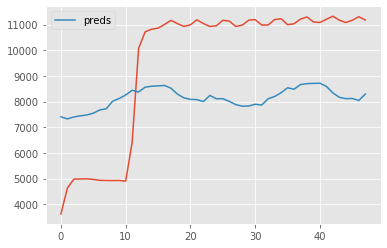

In [26]:
k = 0

plt.plot(trues[k])
plt.plot(preds[k], label='preds')
plt.legend()

In [27]:
test_xy = torch.as_tensor(xy[:, test_idx]).float().cuda()
test_xy_num_feats = torch.as_tensor(
    np.concatenate([xy_series_num[:, test_idx], np.repeat(np.expand_dims(xy_property_num, 1), len(test_idx), 1)], axis=2)).float().cuda()
test_xy_num_feats = torch.as_tensor(test_xy_num_feats).float().cuda()

def plot(x_true, y_true, y_pred):
    enc_ticks = np.arange(x_true.shape[1])
    dec_ticks = np.arange(y_pred.shape[1]) + x_true.shape[1]
    for idx, name in enumerate(power.index):
        plt.figure(figsize=(12, 3))
        plt.plot(enc_ticks, x_true[idx])
        plt.plot(dec_ticks, y_pred[idx], label='pred')
        plt.plot(dec_ticks, y_true[idx], label='true')
        plt.title(name)
        plt.legend()

def wmape(y_hat, y):
    scores = []
    for day in range(int(y.shape[0] / 24)):
        scores.append(np.abs(y[day*24: (day+1)*24] - y_hat[day*24: (day+1)*24]).sum() / np.sum(y[day*24: (day+1)*24]))
    return scores

def metric(y_true, y_pred):
    scores = {}
    for idx, name in enumerate(power.index):
        scores[name] = wmape(y_pred[idx], y_true[idx])
    return pd.DataFrame(scores)


def predict(learner, xy, x_feats, y_feats, epoch):
    learner.load(epoch)
    learner.model.eval()
    learner.model.cuda()
    preds = []
    days = int(xy.shape[1] / 24 - ENC_LEN / 24 - DEC_LEN/24 + 1)
    for day in range(days):
        step = day * 24
        step_pred = model(
            xy[:,step: step+ENC_LEN], 
            enc_num=x_feats[:, step: step+ENC_LEN],
            dec_num=y_feats[:, step+ENC_LEN: step+ENC_LEN+DEC_LEN], 
            dec_len=DEC_LEN
        ).cpu().detach().numpy()
        preds.append(step_pred[:, -24:])
    
    preds = np.concatenate(preds, axis=1)
    preds = np.expm1(preds.squeeze() * xy_std + xy_mean)
    
    x_true = np.expm1(xy[:,:ENC_LEN + 24].cpu().numpy().squeeze() * xy_std + xy_mean)
    y_true = np.expm1(xy[:,ENC_LEN + 24:].cpu().numpy().squeeze() * xy_std + xy_mean)
    
    return x_true, y_true, preds

In [28]:
norm_data = pd.read_csv("../data/20200315_20200415.csv").drop(['Unnamed: 0', 'model_name'], axis=1)
norm_data = norm_data[norm_data.contributor_id.isin(power.index)].reset_index(drop=True)
norm_data = norm_data.set_index("contributor_id").loc[power.index].reset_index()
norm_data['data_time'] = pd.to_datetime(norm_data.data_time)
norm_data = norm_data.set_index("data_time").groupby("contributor_id").resample('1H')[['forecast_pwr', 'value']].sum().reset_index()
norm_true = norm_data.pivot(index='contributor_id', columns='data_time', values='value').iloc[:, 48:]
norm_pred = norm_data.pivot(index='contributor_id', columns='data_time', values='forecast_pwr').iloc[:, 48:]


x_true, y_true, y_pred  = predict(learner, test_xy, test_xy_num_feats, test_xy_num_feats, 844)
scores = pd.DataFrame([metric(y_true, y_pred).mean().rename("wave"), 
                       metric(norm_true.values, norm_pred.values).mean().rename("v1")]).T.dropna()

In [29]:
scores.describe()

wave         v1
count  6.200000e+01  62.000000
mean   6.474132e+08   0.526637
std    5.097736e+09   1.994470
min    2.712593e-02   0.017290
25%    1.565841e-01   0.089047
50%    2.255706e-01   0.171180
75%    3.931230e-01   0.306400
max    4.013962e+10  15.607201

In [31]:
scores

wave        v1
91E0B6DC00B41783E0530BC8100A0E30  0.112635  0.069571
91E0B6DC00B51783E0530BC8100A0E30  0.123536  0.071625
91E0B6DC00B91783E0530BC8100A0E30  0.160514  0.155071
91E0B6DC00BA1783E0530BC8100A0E30  0.076575  0.033071
91E0B6DC00BB1783E0530BC8100A0E30  0.146993  0.124790
...                                    ...       ...
91E0C8BAA1C5259EE0530BC8100AFFB2  0.162674  0.116262
91E0C8BAA1CB259EE0530BC8100AFFB2  0.098529  0.052491
91E1E413742C0582E0530BC8100A3E6E  0.289313  0.241817
9795AE222D56386FE0530BC8100A7150  0.342989  0.420454
9AC089DEFCF45804E0530BC8100A23FC  0.130682  0.175130

[62 rows x 2 columns]

In [32]:
scores.sort_values("wave")

wave         v1
91E0C8BAA1B7259EE0530BC8100AFFB2  2.712593e-02   0.018249
91E0B6DC00FF1783E0530BC8100A0E30  3.701680e-02   0.018072
91E0B6DC00D81783E0530BC8100A0E30  4.547452e-02   0.018146
91E0C8BAA1B2259EE0530BC8100AFFB2  6.809901e-02   0.019696
91E0B6DC00BA1783E0530BC8100A0E30  7.657483e-02   0.033071
...                                        ...        ...
91E0B6DC01411783E0530BC8100A0E30  9.714828e-01   0.876168
91E0C8BAA1B4259EE0530BC8100AFFB2  1.107719e+00   1.114753
91E0C8BAA12E259EE0530BC8100AFFB2  1.678978e+00   3.111139
91E0B6DC00D01783E0530BC8100A0E30  3.173694e+00  15.607201
91E0B6DC00E91783E0530BC8100A0E30  4.013962e+10   0.150747

[62 rows x 2 columns]

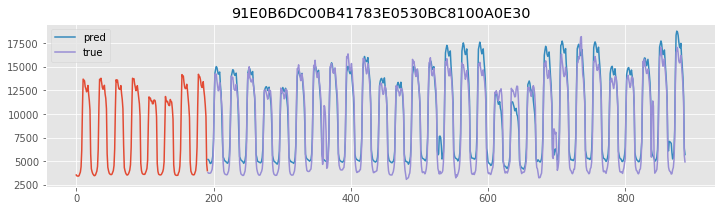

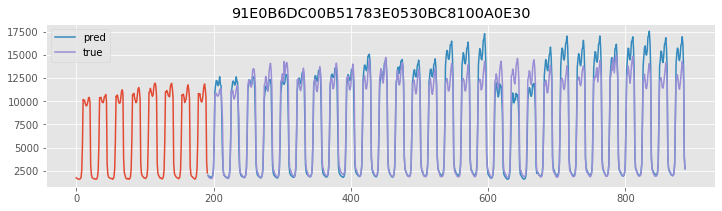

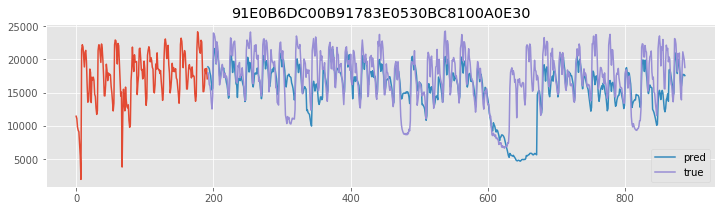

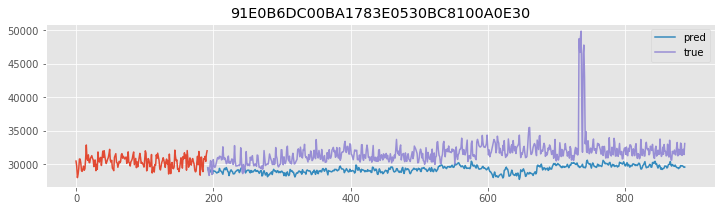

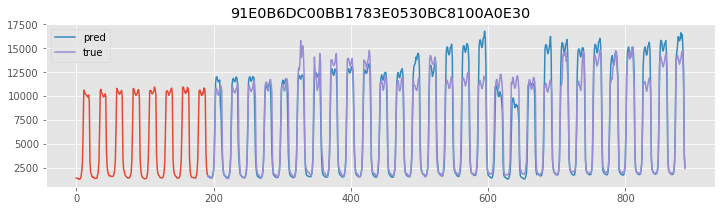

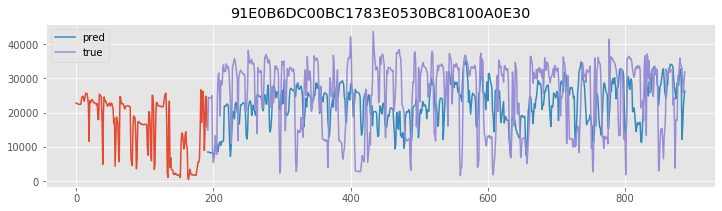

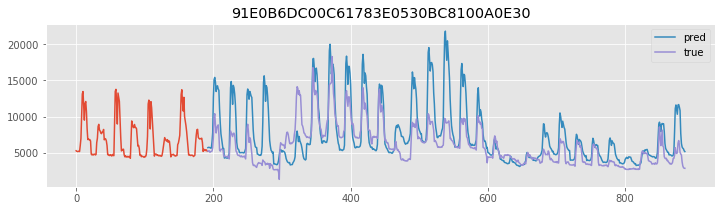

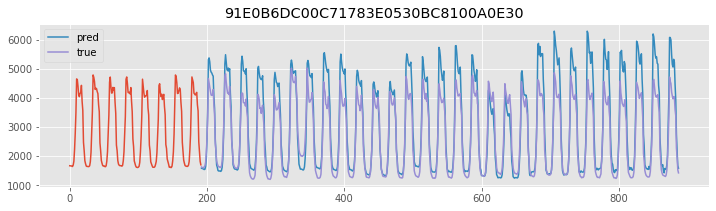

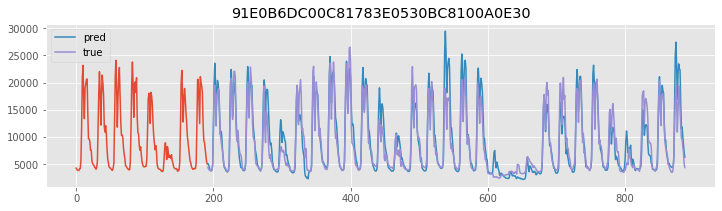

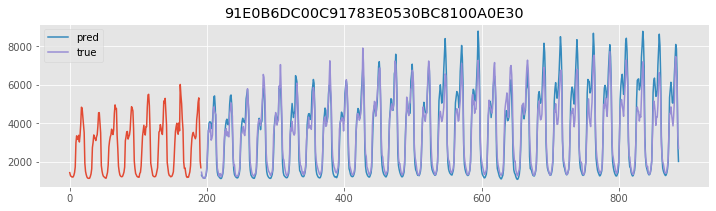

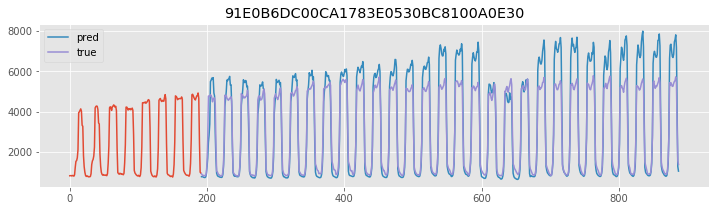

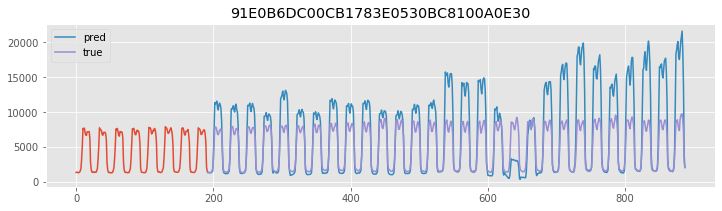

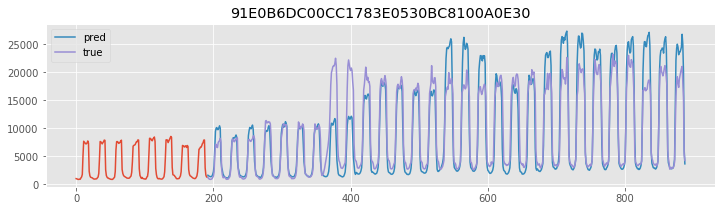

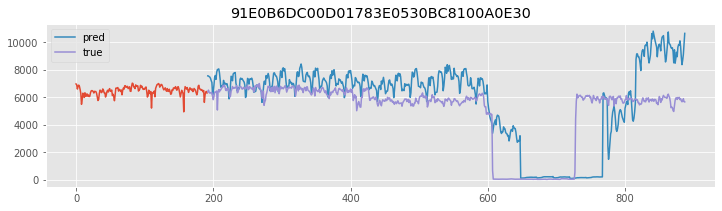

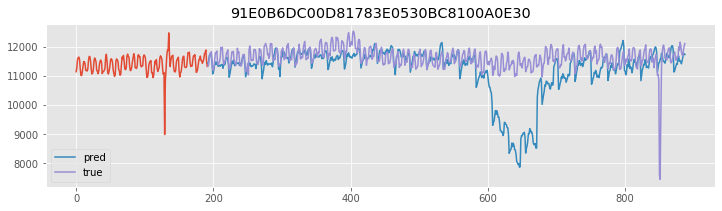

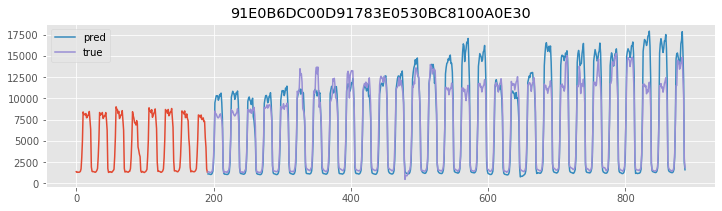

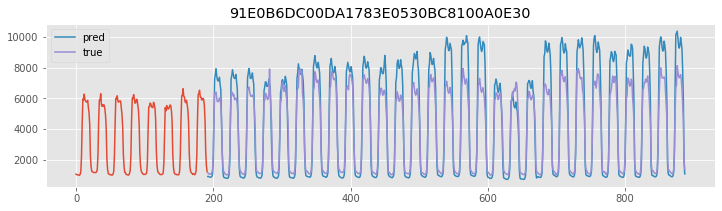

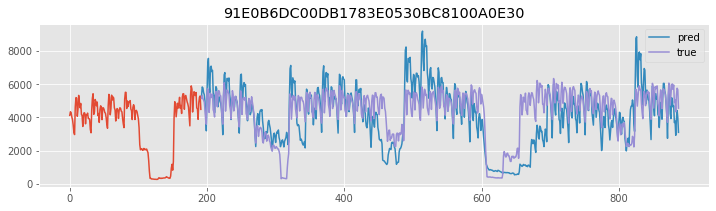

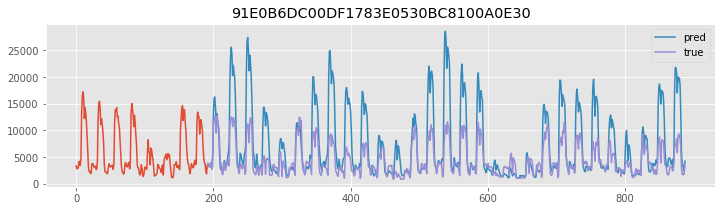

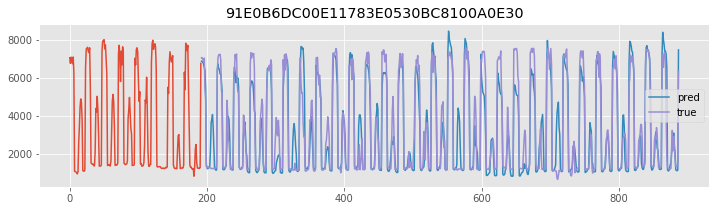

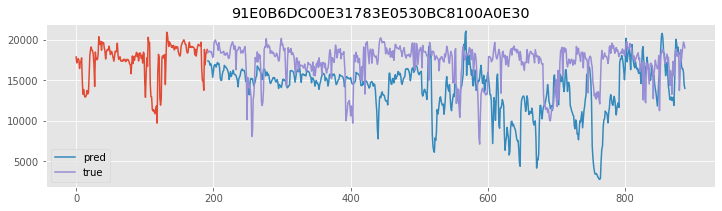

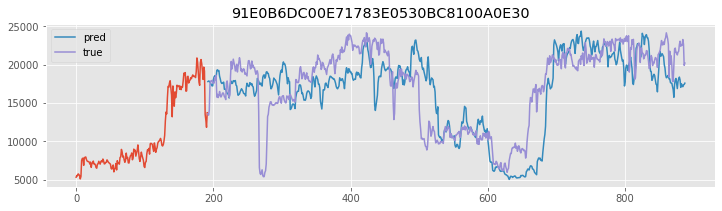

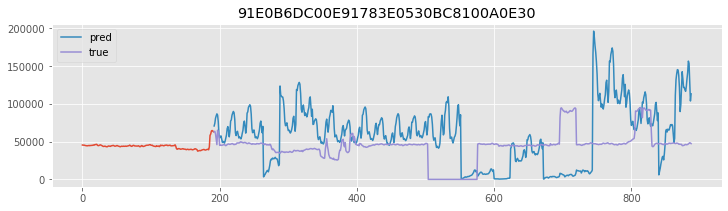

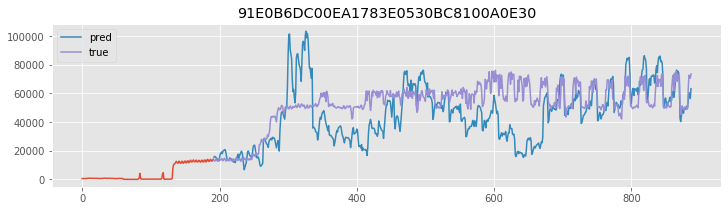

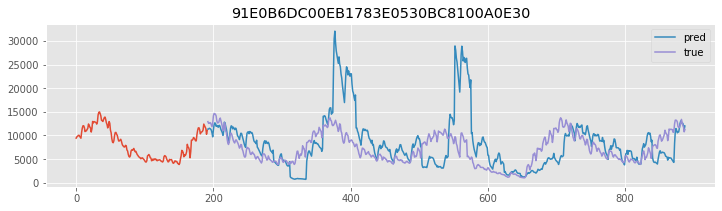

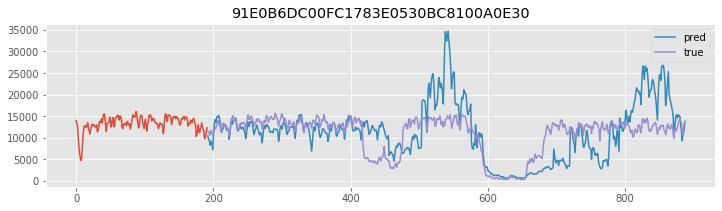

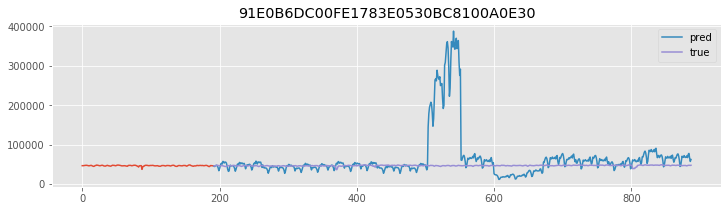

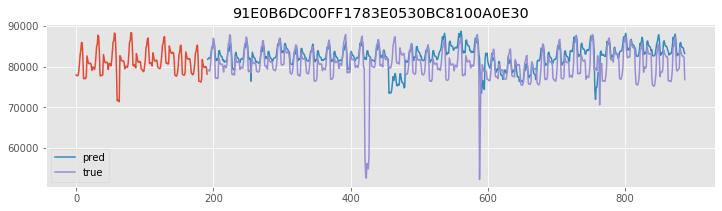

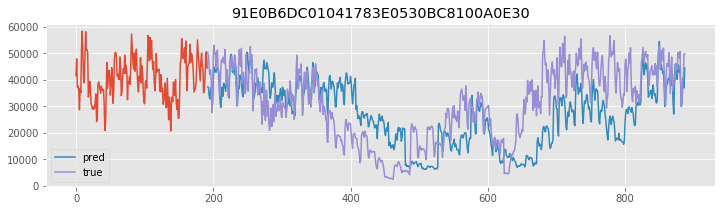

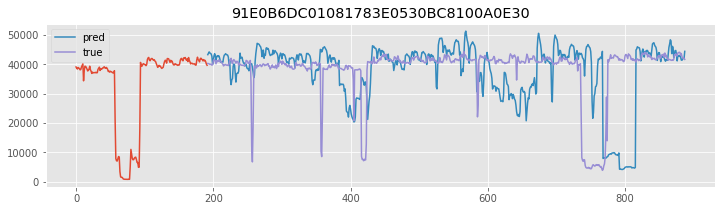

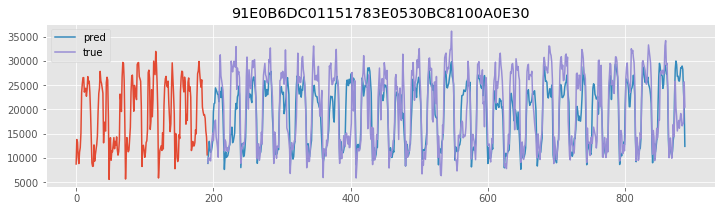

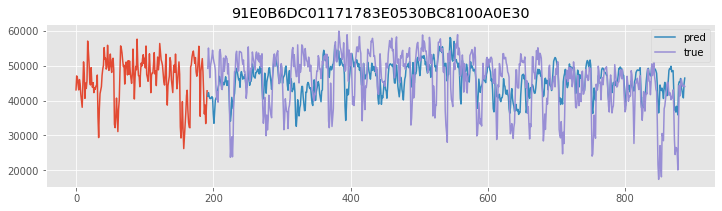

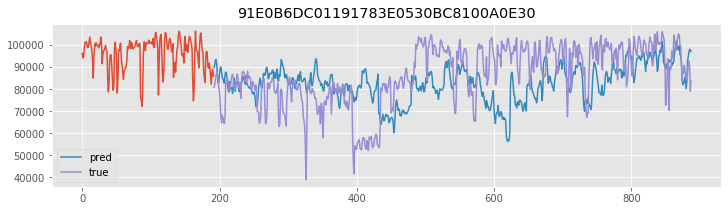

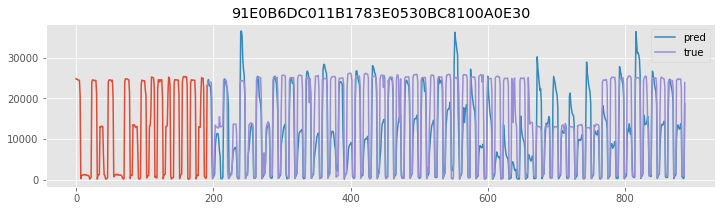

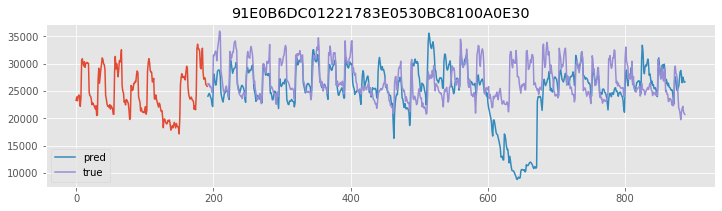

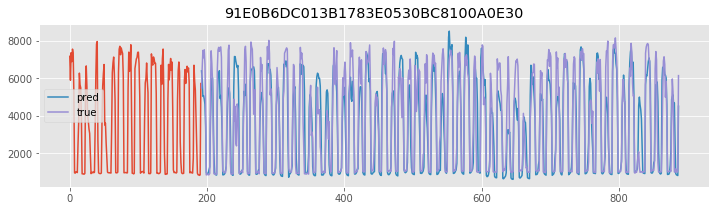

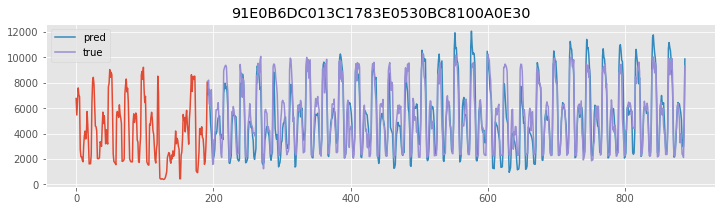

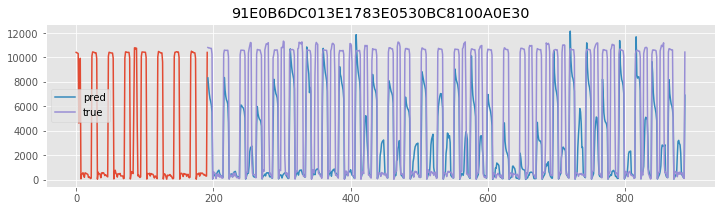

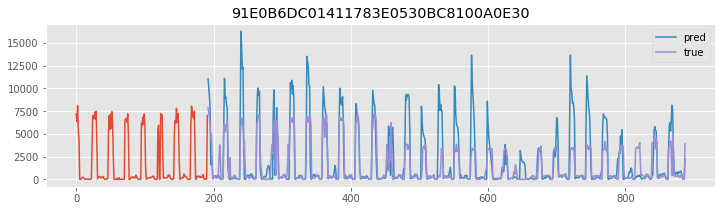

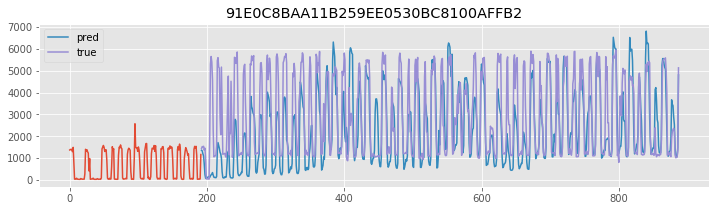

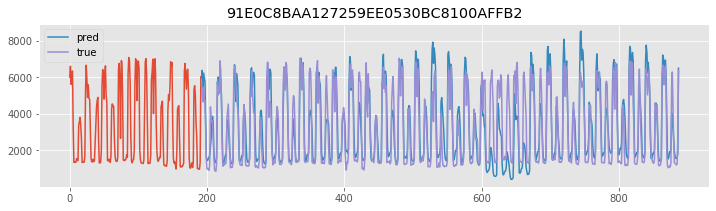

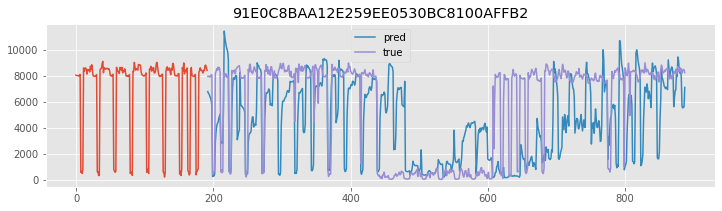

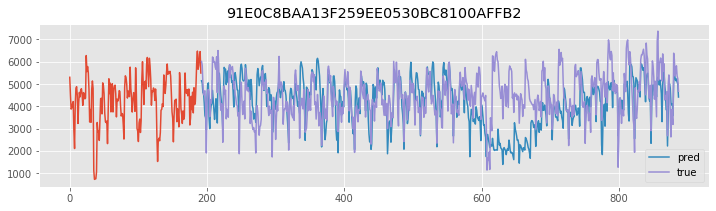

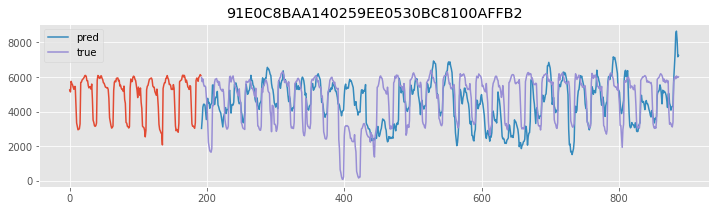

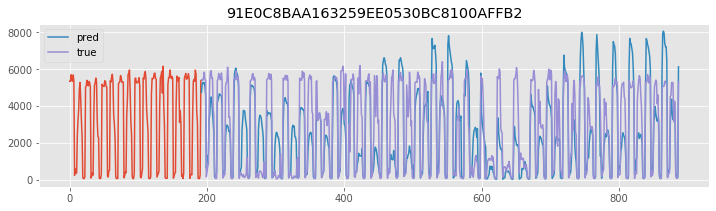

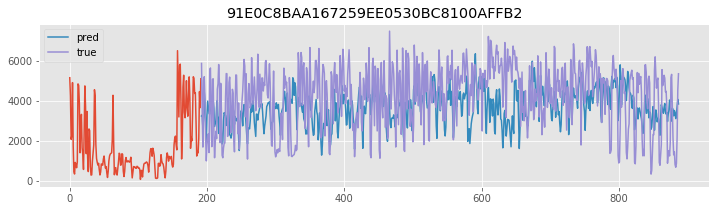

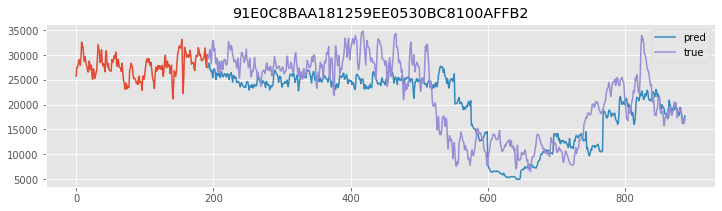

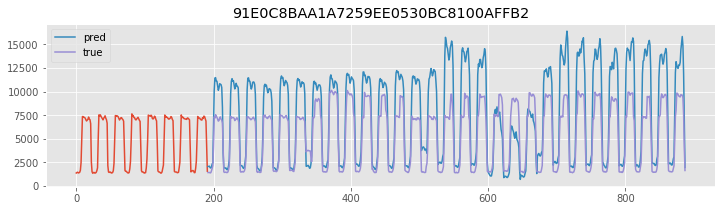

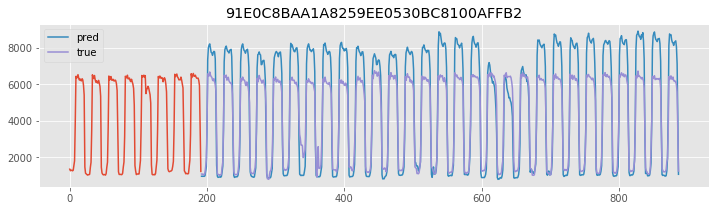

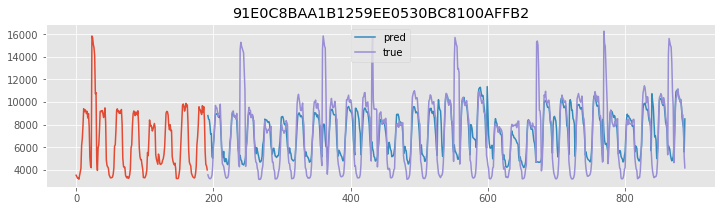

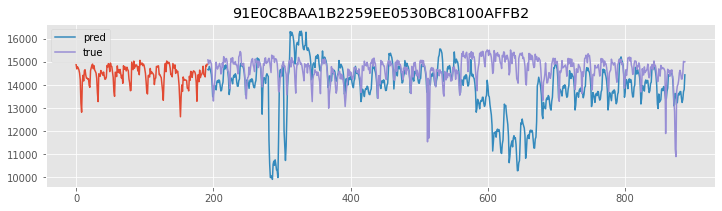

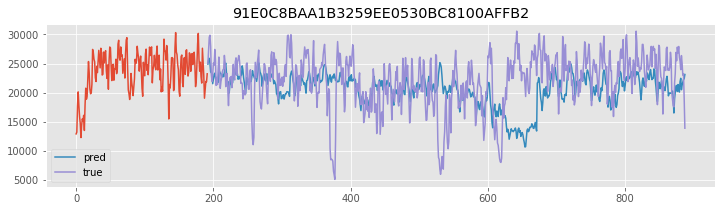

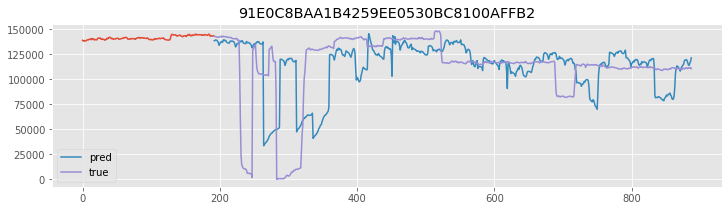

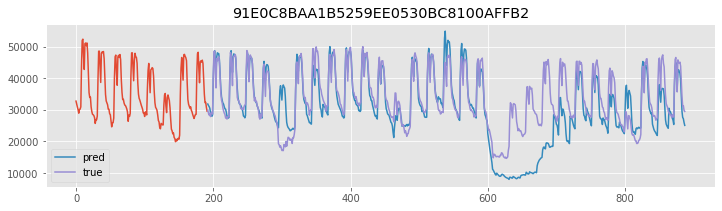

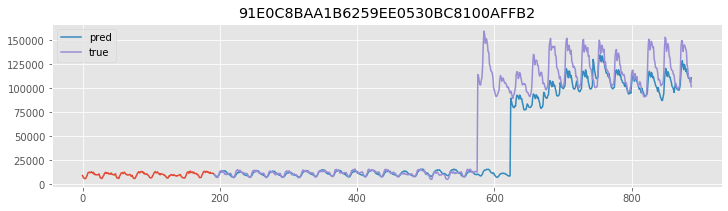

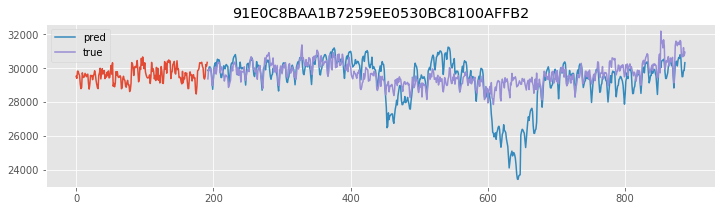

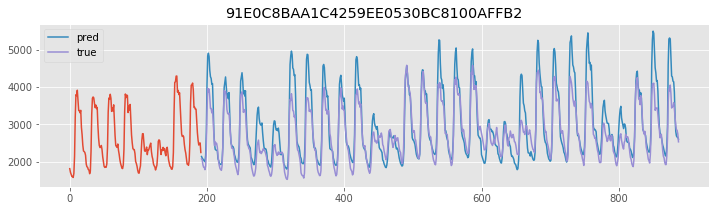

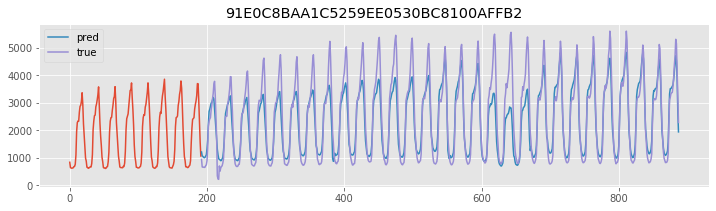

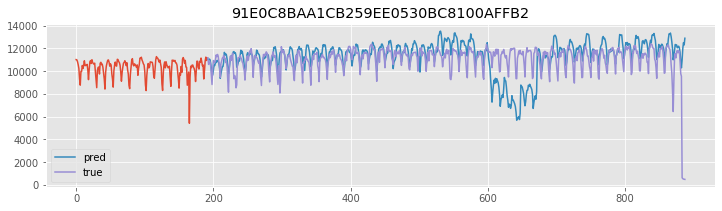

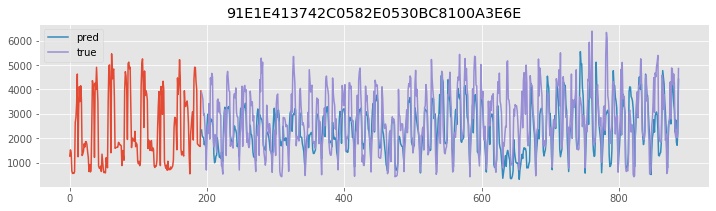

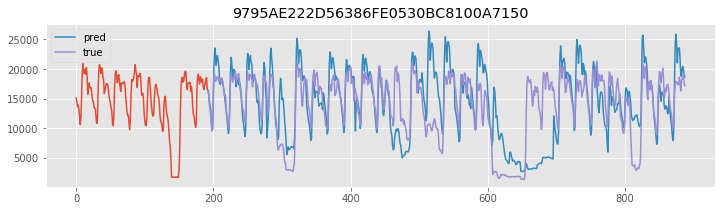

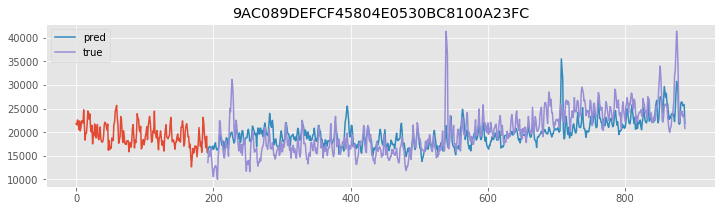

In [33]:
plot(x_true, y_true, y_pred)

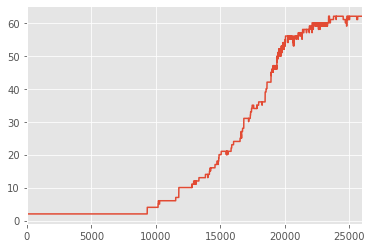

In [83]:
pd.DataFrame(xy_lag_valid[:, -1]).sum().plot()